Mean MSE: Leave one out 0.0340, 10 folds 0.0346, 5 folds 0.0331, 3 folds 0.0341
Mean MSE: Leave one out 0.0334, 10 folds 0.0329, 5 folds 0.0310, 3 folds 0.0450
Mean MSE: Leave one out 0.0316, 10 folds 0.0321, 5 folds 0.0297, 3 folds 0.0340
Mean MSE: Leave one out 0.0783, 10 folds 0.0758, 5 folds 0.0733, 3 folds 0.0890
Mean MSE: Leave one out 0.0459, 10 folds 0.0448, 5 folds 0.0418, 3 folds 0.0522


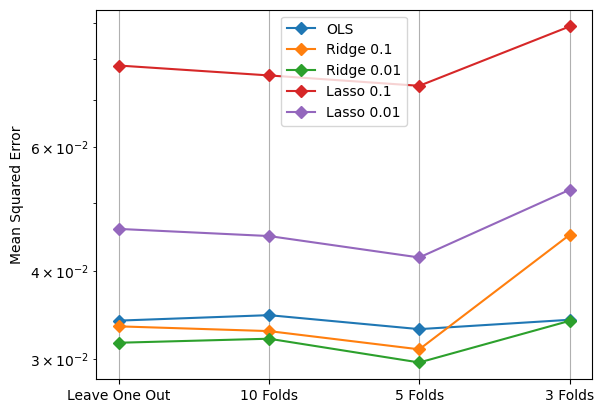

<Figure size 960x720 with 0 Axes>

In [18]:
from numpy import empty
import numpy as np
from numpy.random import seed, uniform, normal
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

seed(10)

def Runge(x):
    return 1 / (1 + 25 * x**2)

std = 0.1
N_POINTS = 50

x = uniform(-1, 1, N_POINTS)
y = Runge(x) + normal(0, std, N_POINTS)
pol = PolynomialFeatures(degree=6
)

 
def cross_validation(k_folds, optimization_method):
    mean_mse = 0.
    for k in range(k_folds):
        train_idx = [i for i in range(N_POINTS) if i%k_folds!=k]
        test_idx = [i for i in range(N_POINTS) if i%k_folds==k]
        
        x_train = x[train_idx]
        y_train = y[train_idx]

        x_test = x[test_idx]
        y_test = y[test_idx]

        X = pol.fit_transform(x_train.reshape(-1, 1))

        scalar = StandardScaler()
        X = scalar.fit_transform(X)
        y_mean = y_train.mean()
        y_train -= y_mean
        y_test -=y_mean
        reg = optimization_method.fit(X, y_train)

        y_pred = reg.predict(scalar.transform(pol.transform(x_test.reshape(-1, 1))))

        mse = mean_squared_error(y_test, y_pred)

        mean_mse += mse / k_folds

    return mean_mse


for optimization_method, name in [
        (LinearRegression(), "OLS"),
        (Ridge(alpha=0.1), "Ridge 0.1"),
        (Ridge(alpha=0.01), "Ridge 0.01"),
        (Lasso(alpha=0.1), "Lasso 0.1"),
        (Lasso(alpha=0.01), "Lasso 0.01")
    ]:

    mean_mse_LEAVE_ONE_OUT = cross_validation(N_POINTS, optimization_method)
    mean_mse_10_FOLDS = cross_validation(10, optimization_method)
    mean_mse_5_FOLDS = cross_validation(5, optimization_method)
    mean_mse_3_FOLDS = cross_validation(3, optimization_method)
    #mean_mse_2_FOLDS = cross_validation(2, optimization_method)

    scalar = StandardScaler()
    X = pol.fit_transform(x.reshape(-1, 1))
    X = scalar.fit_transform(X)
    y_center = y - y.mean()

    reg = optimization_method.fit(X, y_center)
    y_pred = reg.predict(scalar.transform(pol.transform(x.reshape(-1, 1)))) + y.mean()

    print(f"Mean MSE: Leave one out {mean_mse_LEAVE_ONE_OUT:.4f}, 10 folds {mean_mse_10_FOLDS:.4f}, 5 folds {mean_mse_5_FOLDS:.4f}, 3 folds {mean_mse_3_FOLDS:.4f}")
    plt.plot(range(4), [ mean_mse_LEAVE_ONE_OUT, mean_mse_10_FOLDS, mean_mse_5_FOLDS, mean_mse_3_FOLDS], 'D-', label=name)

plt.xticks(range(4), ['Leave One Out', '10 Folds', '5 Folds', '3 Folds'])
plt.ylabel('Mean Squared Error')
plt.legend()
plt.yscale('log')
plt.grid()
plt.figure(dpi=150)
plt.show()

**Compare cross-validation to bootstrap**

2 Bootstraps 0.3731   3 Bootstraps 0.3183   5 Bootstraps 0.3034   10 Bootstraps 0.2871   50 Bootstraps 0.6621   500 Bootstraps 3.9111   1000 Bootstraps 0.5144   2000 Bootstraps 0.6527   
2 Bootstraps 0.0241   3 Bootstraps 0.0312   5 Bootstraps 0.0354   10 Bootstraps 0.0340   50 Bootstraps 0.0364   500 Bootstraps 0.0341   1000 Bootstraps 0.0347   2000 Bootstraps 0.0347   
2 Bootstraps 0.1074   3 Bootstraps 0.0723   5 Bootstraps 0.0345   10 Bootstraps 0.0704   50 Bootstraps 0.1134   500 Bootstraps 0.0786   1000 Bootstraps 0.0942   2000 Bootstraps 0.0859   
2 Bootstraps 0.0590   3 Bootstraps 0.0747   5 Bootstraps 0.0675   10 Bootstraps 0.0674   50 Bootstraps 0.0734   500 Bootstraps 0.0707   1000 Bootstraps 0.0714   2000 Bootstraps 0.0714   
2 Bootstraps 0.0588   3 Bootstraps 0.0759   5 Bootstraps 0.0771   10 Bootstraps 0.0657   50 Bootstraps 0.0736   500 Bootstraps 0.0702   1000 Bootstraps 0.0715   2000 Bootstraps 0.0706   


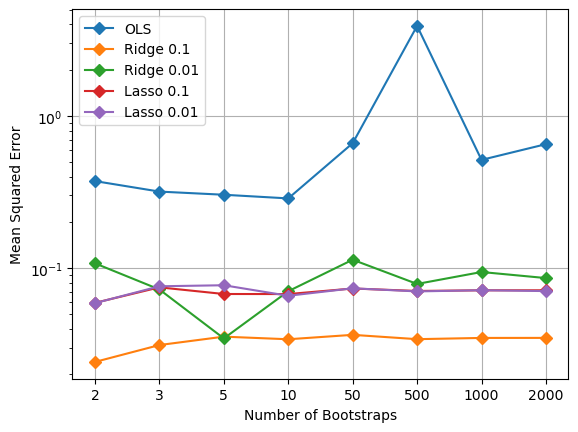

<Figure size 960x720 with 0 Axes>

In [19]:
n_bootstraps = [2, 3, 5, 10, N_POINTS, 500, 1_000, 2_000]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

def bootstrap(optimization_method, name):

    error = []

    for i, n in enumerate(n_bootstraps):
        mse_vals = []
        for j in range(n):
            x_, y_ = resample(x_train, y_train)
            X = pol.fit_transform(x_.reshape(-1, 1))
            model = optimization_method.fit(X, y_)
            y_pred = model.predict(pol.transform(x_test.reshape(-1, 1)))
            mse_vals.append(mean_squared_error(y_test, y_pred))

        error.append(np.mean(mse_vals))

        print(f"{n} Bootstraps {error[i]:.4f}", end="   ")
    
    print()
    scalar = StandardScaler()
    X = pol.fit_transform(x.reshape(-1, 1))
    X = scalar.fit_transform(X)
    y_center = y - y.mean()

    reg = optimization_method.fit(X, y_center)
    y_pred = reg.predict(scalar.transform(pol.transform(x.reshape(-1, 1)))) + y.mean()

    plt.plot(range(len(n_bootstraps)), error, 'D-', label=name)

for optimization_method, name in [
        (LinearRegression(), "OLS"),
        (Ridge(alpha=0.1), "Ridge 0.1"),
        (Ridge(alpha=0.01), "Ridge 0.01"),
        (Lasso(alpha=0.1), "Lasso 0.1"),
        (Lasso(alpha=0.01), "Lasso 0.01")
    ]:
    bootstrap(optimization_method, name)

plt.xticks(range(len(n_bootstraps)), n_bootstraps)
plt.ylabel('Mean Squared Error')
plt.xlabel('Number of Bootstraps')
plt.legend()
plt.yscale('log')
plt.grid()
plt.figure(dpi=150)
plt.show()